In [91]:
#!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.3 MB/s eta 0:00:00


In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

In [97]:
from catboost import CatBoostClassifier

In [98]:
sns.set()

In [99]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# **Data Understanding**

In [100]:
df_dislok = pd.read_parquet('/content/drive/MyDrive/datawago23/dislok_wagons.parquet')
df_freight = pd.read_parquet('/content/drive/MyDrive/datawago23/freight_info.parquet')
df_kti = pd.read_parquet('/content/drive/MyDrive/datawago23/kti_izm.parquet')
df_pr = pd.read_parquet('/content/drive/MyDrive/datawago23/pr_rems.parquet')
df_stations = pd.read_parquet('/content/drive/MyDrive/datawago23/stations.parquet')
df_tr = pd.read_parquet('/content/drive/MyDrive/datawago23/tr_rems.parquet')
df_wag = pd.read_parquet('/content/drive/MyDrive/datawago23/wag_params.parquet')
df_probeg = pd.read_parquet('/content/drive/MyDrive/datawago23/wagons_probeg_ownersip.parquet')

In [101]:
dfs = [df_dislok, df_freight, df_kti, df_pr, df_stations, df_tr, df_wag, df_probeg]

In [102]:
for i in dfs:
    print(i.duplicated().sum())

24
0
0
0
131787
166
0
0


In [103]:
df_dislok = df_dislok.drop_duplicates().reset_index(drop=True)
df_stations = df_stations.drop_duplicates().reset_index(drop=True)
df_tr = df_tr.drop_duplicates().reset_index(drop=True)

In [104]:
y_train = pd.read_csv('/content/drive/MyDrive/datawago23/y_train.csv')

In [105]:
df_dislok.head()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,22,42,11470,42,36899,0,5032,1413,-1.0
1,2022-08-02,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36899,1,1204,1204,998.0
2,2022-08-03,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,989.0
3,2022-08-04,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,939.0
4,2022-08-05,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,963.0


In [106]:
df_dislok['kap_year'] = df_dislok['date_kap'].dt.year
df_dislok['kap_month'] = df_dislok['date_kap'].dt.month

In [107]:
df_dislok['plrem_year'] = df_dislok['date_pl_rem'].dt.year
df_dislok['plrem_month'] = df_dislok['date_pl_rem'].dt.month

In [108]:
df_dislok['dep_year'] = df_dislok['date_dep'].dt.year
df_dislok['dep_month'] = df_dislok['date_dep'].dt.month

In [109]:
df_dislok = df_dislok.drop(['date_kap', 'date_pl_rem', 'date_dep'], axis=1)

In [110]:
df_dislok.head()

,plan_date,wagnum,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month
0,2022-08-01,1071,0,42,22,42,11470,42,36899,0,5032,1413,-1.0,NaN,NaN,2023,2,2020.0,2.0
1,2022-08-02,1071,0,42,11663,0,11470,42,36899,1,1204,1204,998.0,NaN,NaN,2023,2,2020.0,2.0
2,2022-08-03,1071,0,42,11663,0,11470,42,36711,1,1204,1204,989.0,NaN,NaN,2023,2,2020.0,2.0
3,2022-08-04,1071,0,42,11663,0,11470,42,36711,1,1204,1204,939.0,NaN,NaN,2023,2,2020.0,2.0
4,2022-08-05,1071,0,42,11663,0,11470,42,36711,1,1204,1204,963.0,NaN,NaN,2023,2,2020.0,2.0


In [111]:
df_dislok.shape

(6250909, 19)

In [112]:
df_dislok.isna().sum()

plan_date             0
wagnum                0
kod_vrab              0
id_road_disl          0
st_id_dest            0
id_road_dest          0
st_id_send            0
id_road_send          0
ost_prob         257315
isload                0
fr_id                 0
last_fr_id            0
distance              0
kap_year        2755021
kap_month       2755021
plrem_year            0
plrem_month           0
dep_year         351873
dep_month        351873
dtype: int64

In [113]:
df_freight.head()

,fr_id,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,4989,2,0,0,0,0,0,0,0
1,4990,2,0,0,0,0,0,0,0
2,4991,0,0,0,0,0,0,0,0
3,4992,2,0,0,0,0,0,0,0
4,4993,2,0,0,0,0,0,0,0


In [114]:
df_freight.shape

(5079, 9)

In [115]:
df_freight.isna().sum()

fr_id         0
fr_class      0
skoroport     0
naval         0
nasip         0
naliv         0
openvagons    0
soprovod      0
smerz         0
dtype: int64

In [116]:
df_kti.head()

,wagnum,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
43,1302,2023-02-17,67638.0,29.6,29.5,30.0,29.6,30.2,29.9,30.9,29.5,37.8,39.2,39.5,38.9,41.8,38.9,36.5,38.2
60,1374,2023-02-25,83798.0,29.1,27.9,27.7,29.1,29.3,30.2,29.4,27.5,48.9,49.0,49.7,51.0,30.7,32.4,30.6,28.8
137,2916,2023-02-21,121660.0,30.4,26.5,30.8,28.2,26.9,27.1,29.8,31.2,69.2,66.7,66.8,63.7,66.1,66.3,68.1,67.6
196,3849,2023-02-19,59664.0,30.6,29.2,31.6,28.5,31.0,30.7,29.3,30.0,75.1,76.1,74.8,73.7,75.6,76.8,72.2,72.9
197,3849,2023-02-20,59664.0,30.9,28.7,32.4,28.1,31.0,29.7,30.5,29.9,75.6,76.8,74.1,74.7,75.8,77.0,74.9,74.2


In [117]:
df_kti.isna().sum()

wagnum                   0
operation_date_dttm      0
mileage_all            273
axl1_l_w_flange         12
axl1_r_w_flange         19
axl2_l_w_flange         16
axl2_r_w_flange         20
axl3_l_w_flange         17
axl3_r_w_flange         21
axl4_l_w_flange         15
axl4_r_w_flange         12
axl1_l_w_rim           141
axl1_r_w_rim           132
axl2_l_w_rim           135
axl2_r_w_rim           136
axl3_l_w_rim           177
axl3_r_w_rim           155
axl4_l_w_rim           122
axl4_r_w_rim           110
dtype: int64

In [118]:
df_kti['operation_date_dttm'] = pd.to_datetime(df_kti['operation_date_dttm'])

In [119]:
df_kti.shape

(22428, 19)

In [120]:
df_pr.head()

,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37.0,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360.0,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322.0,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308.0,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373.0,8


In [121]:
df_pr.shape

(10441, 11)

In [122]:
df_pr.isna().sum()

wagnum          0
rem_month       0
rod_id          0
model           0
road_id_send    0
road_id_rem     0
kod_vrab        0
st_id_send      0
st_id_rem       0
distance        0
month           0
dtype: int64

In [123]:
df_stations.head()

,st_id,road_id,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign
0,13069,47,0,0,0,0,0,0,0
1,9353,18,0,0,0,0,0,0,0
2,9973,19,0,0,0,0,0,1,0
3,13745,6,0,0,0,0,0,0,0
4,14554,15,0,0,0,0,0,0,0


In [124]:
df_stations.shape

(16245, 9)

In [125]:
df_stations.isna().sum()

st_id                0
road_id              0
st_border_sign       0
st_sea_sign          0
st_river_sign        0
st_car_sign          0
st_ferry_sign        0
st_freigh_sign       0
opor_station_sign    0
dtype: int64

In [126]:
df_tr.head()

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789


In [127]:
df_tr.shape

(48486, 17)

In [128]:
df_tr.isna().sum()

wagnum            0
rem_month         0
kod_vrab          0
neis1_kod         0
neis2_kod         0
neis3_kod         0
mod1_kod          0
mod2_kod          0
mod3_kod          0
mod4_kod          0
mod5_kod          0
mod6_kod          0
mod7_kod          0
road_id_send      0
gr_probeg       719
por_probeg      664
st_id_send        0
dtype: int64

In [129]:
df_wag.head()

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1


In [130]:
df_wag.shape

(33977, 20)

In [131]:
df_wag['build_year'] = df_wag['date_build'].dt.year
df_wag['build_month'] = df_wag['date_build'].dt.month
df_wag['build_day'] = df_wag['date_build'].dt.day

In [132]:
df_wag['sl_year'] = df_wag['srok_sl'].dt.year
df_wag['sl_month'] = df_wag['srok_sl'].dt.month
df_wag['sl_day'] = df_wag['srok_sl'].dt.day

In [133]:
df_wag['iskl_year'] = df_wag['date_iskl'].dt.year
df_wag['iskl_month'] = df_wag['date_iskl'].dt.month
df_wag['iskl_day'] = df_wag['date_iskl'].dt.day

In [134]:
df_wag = df_wag.drop(['date_build', 'srok_sl', 'date_iskl'], axis=1)

In [135]:
df_wag.head()

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day
3218,26318,12-600-04,1,682,682,85.0,240,5,160,160,2,9,3,6,11,110000,0,1992,12,25,2022,4,27,2023.0,2.0,16.0
19128,28344,12-132,1,700,700,88.0,240,0,110,160,2,9,2,1,12,0,0,2003,8,12,2024,12,24,2022.0,12.0,14.0
21526,8099,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,1,160000,1,1995,8,31,2027,10,1,NaN,NaN,NaN
32353,33350,12-9850-02,1,750,750,90.0,248,19,250,500,2,11,2,7,12,250000,1,2014,10,27,2047,2,5,NaN,NaN,NaN
81,5308,11-276,0,680,680,122.0,260,1,110,160,2,9,2,1,11,160000,1,1995,9,17,2027,9,28,NaN,NaN,NaN


In [136]:
df_wag['tipvozd'] = df_wag['tipvozd'].astype(int)

In [137]:
df_wag.isna().sum()

wagnum                    0
model                     0
rod_id                    0
gruz                      0
cnsi_gruz_capacity        0
cnsi_volumek              0
tara                      0
zavod_build               0
cnsi_probeg_dr            0
cnsi_probeg_kr            0
kuzov                     0
telega                    0
tormoz                    0
tipvozd                   0
tippogl                  59
norma_km                  0
ownertype                 0
build_year                0
build_month               0
build_day                 0
sl_year                   0
sl_month                  0
sl_day                    0
iskl_year             33861
iskl_month            33861
iskl_day              33861
dtype: int64

In [138]:
df_probeg.head()

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8


In [139]:
df_probeg.repdate.min()

Timestamp('2022-08-01 00:00:00')

In [140]:
df_probeg.shape

(6249857, 8)

In [141]:
df_probeg.isna().sum()

repdate                0
wagnum                 0
ost_prob          256959
manage_type            0
rod_id                 0
reestr_state           0
ownership_type         0
month                  0
dtype: int64

In [142]:
y_train

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0
...,...,...,...,...
203848,25045,2022-12-01,0,0
203849,27156,2022-12-01,0,0
203850,21361,2022-12-01,0,0
203851,8061,2022-12-01,0,0


In [143]:
y_train.month = pd.to_datetime(y_train.month )

In [144]:
y_train.month.nunique()

6

In [145]:
y_train.shape

(203853, 4)

# **Smart Merge**

In [146]:
df_probeg.shape, df_kti.shape

((6249857, 8), (22428, 19))

In [147]:
df_probeg['wagnum'].nunique()

33977

In [148]:
oot_df = df_probeg[df_probeg['repdate'] == '2023-01-31']

In [149]:
oot_df.shape

(33708, 8)

In [150]:
df_probeg = df_probeg[df_probeg['repdate'].dt.day==1]

In [151]:
df_probeg = pd.concat([df_probeg, oot_df])

In [154]:
df_probeg

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
31,2022-09-01,33361,4105,0,1,1,0,9
61,2022-10-01,33361,2185,0,1,1,0,10
92,2022-11-01,33361,1236,0,1,1,0,11
122,2022-12-01,33361,159916,0,1,1,0,12
...,...,...,...,...,...,...,...,...
9248402,2023-01-31,17621,76867,0,1,1,0,1
9248675,2023-01-31,25045,140342,0,1,1,0,1
9248948,2023-01-31,27156,133393,0,1,1,0,1
9249221,2023-01-31,21361,130398,0,1,1,0,1


In [155]:
data = df_probeg.merge(df_wag, on='wagnum')

In [156]:
data.shape

(237560, 33)

In [157]:
data

,repdate,wagnum,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day
0,2022-08-01,33361,7541,0,1,1,0,8,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
1,2022-09-01,33361,4105,0,1,1,0,9,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
2,2022-10-01,33361,2185,0,1,1,0,10,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
3,2022-11-01,33361,1236,0,1,1,0,11,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
4,2022-12-01,33361,159916,0,1,1,0,12,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237555,2022-11-01,8061,157921,0,0,1,0,11,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237556,2022-12-01,8061,156895,0,0,1,0,12,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237557,2023-01-01,8061,149388,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237558,2023-01-31,8061,140004,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN


In [160]:
data.isna().sum()

repdate                    0
wagnum                     0
ost_prob                9771
manage_type                0
rod_id_x                   0
reestr_state               0
ownership_type             0
month                      0
model                      0
rod_id_y                   0
gruz                       0
cnsi_gruz_capacity         0
cnsi_volumek               0
tara                       0
zavod_build                0
cnsi_probeg_dr             0
cnsi_probeg_kr             0
kuzov                      0
telega                     0
tormoz                     0
tipvozd                    0
tippogl                  413
norma_km                   0
ownertype                  0
build_year                 0
build_month                0
build_day                  0
sl_year                    0
sl_month                   0
sl_day                     0
iskl_year             236770
iskl_month            236770
iskl_day              236770
dtype: int64

In [161]:
data = data.drop(['iskl_month', 'iskl_year', 'iskl_day'], axis=1)

In [162]:
data.shape

(237560, 30)

-------------------

In [80]:
data = data.merge(df_dislok, left_on=['repdate','wagnum'], right_on=['plan_date', 'wagnum'])

In [83]:
data.shape

(203843, 51)

In [159]:
data

,repdate,wagnum,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day
0,2022-08-01,33361,7541,0,1,1,0,8,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
1,2022-09-01,33361,4105,0,1,1,0,9,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
2,2022-10-01,33361,2185,0,1,1,0,10,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
3,2022-11-01,33361,1236,0,1,1,0,11,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
4,2022-12-01,33361,159916,0,1,1,0,12,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237555,2022-11-01,8061,157921,0,0,1,0,11,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237556,2022-12-01,8061,156895,0,0,1,0,12,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237557,2023-01-01,8061,149388,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN
237558,2023-01-31,8061,140004,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,NaN,NaN,NaN


In [91]:
df_tr['wagnum'].value_counts()

11274    12
27679    12
27864    12
11268    12
14223    12
         ..
15626     1
20560     1
10355     1
21251     1
16226     1
Name: wagnum, Length: 17849, dtype: int64

In [94]:
df_pr

,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37.0,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360.0,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322.0,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308.0,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373.0,8
...,...,...,...,...,...,...,...,...,...,...,...
1578,11193,2023-01-30,1,12-132,12,12,0,12607,12607,885.0,1
509,24703,2023-01-24,1,12-9780,6,6,1,4025,4025,890.0,1
511,26437,2023-01-29,1,12-9780,6,6,1,4025,4025,892.0,1
711,29345,2023-01-15,1,12-132,13,13,1,6152,5960,397.0,1


In [93]:
df_tr[df_tr['wagnum'] == 11274]

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
12726,11274,2022-09-01,2,87,62,54,7,4,2,0,0,0,0,38,57411,34144,10363
12727,11274,2022-09-01,2,0,98,54,7,4,2,0,0,0,0,38,57411,34389,10317
17300,11274,2022-10-01,2,0,98,54,7,4,2,0,0,0,0,11,61970,34502,2199
17301,11274,2022-10-01,2,95,98,54,7,4,2,0,0,0,0,11,61970,34502,2271
37997,11274,2022-12-01,3,2,98,54,7,4,2,0,0,0,0,44,70117,39057,12386
37998,11274,2022-12-01,3,0,98,54,7,4,2,0,0,0,0,44,70117,39078,12377
40895,11274,2023-01-01,3,125,98,54,7,4,2,0,0,0,0,40,70117,43998,10905
40896,11274,2023-01-01,2,0,98,54,7,4,2,0,0,0,0,38,70321,45660,10016
40897,11274,2023-01-01,2,88,98,54,7,4,2,0,0,0,0,38,70321,45660,10016
40898,11274,2023-01-01,3,0,98,54,1,4,2,0,0,0,0,40,70117,44247,10847


# **Data Prep**

In [49]:
df_wag['model'].nunique()

50

In [50]:
df_pr['model'].nunique()

39

In [51]:
df_wag['norma_km'].value_counts()

160000    31291
350000      753
0           749
110000      642
500000      490
210000       50
250000        1
320000        1
Name: norma_km, dtype: Int64

In [52]:
df_dislok['distance'] = df_dislok['distance'].apply(lambda x: 0 if x == -1 else x)

In [53]:
df = df_probeg.merge(df_dislok, left_on = ['repdate', 'wagnum'], right_on=['plan_date', 'wagnum'])

In [54]:
df

,repdate,wagnum,ost_prob_x,manage_type,rod_id,reestr_state,ownership_type,month,plan_date,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month
0,2022-08-01,33361,7541,0,1,1,0,8,2022-08-01,0,29,9446,37,7014,29,7541,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0
1,2022-08-02,33361,7243,0,1,1,0,8,2022-08-02,0,30,9446,37,7014,29,7243,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0
2,2022-08-03,33361,6990,0,1,1,0,8,2022-08-03,0,30,9446,37,7014,29,6990,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0
3,2022-08-04,33361,6347,0,1,1,0,8,2022-08-04,0,37,9446,37,7014,29,6347,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0
4,2022-08-05,33361,6027,0,1,1,0,8,2022-08-05,0,37,9446,37,7014,29,6027,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249287,2022-12-20,33350,35062,0,1,0,0,12,2022-12-20,0,38,10364,38,9999,38,35062,0,5032,740,0.0,NaN,NaN,2022,7,2020.0,7.0
6249288,2022-12-21,33350,35062,0,1,0,0,12,2022-12-21,0,38,10364,38,9999,38,35062,0,5032,740,0.0,NaN,NaN,2022,7,2020.0,7.0
6249289,2022-12-22,33350,35062,0,1,0,0,12,2022-12-22,0,38,10364,38,9999,38,35062,0,5032,740,0.0,NaN,NaN,2022,7,2020.0,7.0
6249290,2022-12-23,33350,35062,0,1,0,0,12,2022-12-23,0,38,10364,38,9999,38,35062,0,5032,740,0.0,NaN,NaN,2022,7,2020.0,7.0


In [55]:
df = df.merge(df_wag, on='wagnum')

In [56]:
df = df.merge(df_kti, left_on=['repdate', 'wagnum'], right_on=['operation_date_dttm', 'wagnum'], how='left')

In [57]:
df = df.merge(df_freight, on='fr_id')

In [58]:
df.duplicated().sum()

0

In [59]:
df.shape

(6094278, 77)

In [60]:
df.repdate.min(), df.repdate.max()

(Timestamp('2022-08-01 00:00:00'), Timestamp('2023-01-31 00:00:00'))

# **ML**

In [67]:
le = LabelEncoder()

In [68]:
df['model'] = le.fit_transform(df['model'])

In [69]:
df

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,month,plan_date,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,2022-08-01,33361,7541,0,1,1,0,8,2022-08-01,0,29,9446,37,7014,29,7541,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0
1,2022-08-02,33361,7243,0,1,1,0,8,2022-08-02,0,30,9446,37,7014,29,7243,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0
2,2022-08-03,33361,6990,0,1,1,0,8,2022-08-03,0,30,9446,37,7014,29,6990,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0
3,2022-08-04,33361,6347,0,1,1,0,8,2022-08-04,0,37,9446,37,7014,29,6347,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0
4,2022-08-05,33361,6027,0,1,1,0,8,2022-08-05,0,37,9446,37,7014,29,6027,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6094273,2022-12-02,32417,206339,1,1,1,0,12,2022-12-02,0,38,10232,38,12380,44,206339,1,3823,714,0.0,NaN,NaN,2025,7,2021.0,7.0,25,1,750,750,94.0,248,0,350,500,43,11,2,7,11,350000,1,2019,5,6,2050,4,30,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0
6094274,2022-12-03,32417,206277,1,1,1,0,12,2022-12-03,0,38,22,38,12380,44,206277,1,3823,714,0.0,NaN,NaN,2025,7,2021.0,7.0,25,1,750,750,94.0,248,0,350,500,43,11,2,7,11,350000,1,2019,5,6,2050,4,30,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0
6094275,2022-12-04,32417,206264,1,1,1,0,12,2022-12-04,0,38,22,38,10232,38,206264,0,3823,714,0.0,NaN,NaN,2025,7,2021.0,7.0,25,1,750,750,94.0,248,0,350,500,43,11,2,7,11,350000,1,2019,5,6,2050,4,30,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0
6094276,2023-01-30,4086,149936,0,0,1,0,1,2023-01-30,0,16,12038,43,4524,16,149936,1,2813,2813,0.0,NaN,NaN,2022,12,2019.0,12.0,5,0,670,670,161.0,268,1,110,160,2,9,2,16,11,160000,0,2016,4,10,2046,7,3,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0


In [76]:
df.isna().sum()

repdate                     0
wagnum                      0
ost_prob_x             240759
manage_type                 0
rod_id_x                    0
reestr_state                0
ownership_type              0
month                       0
kod_vrab                    0
id_road_disl                0
st_id_dest                  0
id_road_dest                0
st_id_send                  0
id_road_send                0
ost_prob_y             240759
isload                      0
fr_id                       0
last_fr_id                  0
distance                    0
kap_year              2672760
kap_month             2672760
plrem_year                  0
plrem_month                 0
dep_year               330696
dep_month              330696
model                       0
rod_id_y                    0
gruz                        0
cnsi_gruz_capacity          0
cnsi_volumek                0
tara                        0
zavod_build                 0
cnsi_probeg_dr              0
cnsi_probe

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6094278 entries, 0 to 6094277
Data columns (total 77 columns):
 #   Column               Dtype         
---  ------               -----         
 0   repdate              datetime64[ns]
 1   wagnum               int64         
 2   ost_prob_x           Int64         
 3   manage_type          int64         
 4   rod_id_x             int64         
 5   reestr_state         int64         
 6   ownership_type       int64         
 7   month                int64         
 8   plan_date            datetime64[ns]
 9   kod_vrab             int64         
 10  id_road_disl         int64         
 11  st_id_dest           int64         
 12  id_road_dest         int64         
 13  st_id_send           int64         
 14  id_road_send         int64         
 15  ost_prob_y           Int64         
 16  isload               Int64         
 17  fr_id                int64         
 18  last_fr_id           int64         
 19  distance             

In [71]:
df = df.drop(['plan_date', 'operation_date_dttm'], axis=1)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6094278 entries, 0 to 6094277
Data columns (total 75 columns):
 #   Column              Dtype         
---  ------              -----         
 0   repdate             datetime64[ns]
 1   wagnum              int64         
 2   ost_prob_x          Int64         
 3   manage_type         int64         
 4   rod_id_x            int64         
 5   reestr_state        int64         
 6   ownership_type      int64         
 7   month               int64         
 8   kod_vrab            int64         
 9   id_road_disl        int64         
 10  st_id_dest          int64         
 11  id_road_dest        int64         
 12  st_id_send          int64         
 13  id_road_send        int64         
 14  ost_prob_y          Int64         
 15  isload              Int64         
 16  fr_id               int64         
 17  last_fr_id          int64         
 18  distance            float64       
 19  kap_year            float64       
 20  ka

In [73]:
data = df.merge(y_train, left_on=['repdate', 'wagnum'], right_on=['month', 'wagnum'])

In [74]:
data

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,month_x,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz,month_y,target_month,target_day
0,2022-08-01,33361,7541,0,1,1,0,8,0,29,9446,37,7014,29,7541,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2022-08-01,0,0
1,2022-09-01,33364,31596,0,1,1,0,9,0,37,9540,37,6856,29,31596,0,2255,1655,0.0,2020.0,10.0,2023,10,2018.0,4.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,4,21,2031,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2022-09-01,0,0
2,2022-11-01,33364,16969,0,1,1,0,11,0,42,10348,38,12202,44,16969,0,2255,714,3627.0,2020.0,10.0,2023,10,2018.0,4.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,4,21,2031,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2022-11-01,0,0
3,2023-01-01,33364,157426,0,1,1,0,1,0,36,10348,38,8921,36,157426,0,2255,637,0.0,2020.0,10.0,2023,10,2018.0,4.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,4,21,2031,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2023-01-01,0,0
4,2022-09-01,33366,9354,0,1,1,0,9,1,28,22,28,4789,28,9354,0,2255,615,0.0,NaN,NaN,2023,4,2020.0,4.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,6,23,2032,1,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2022-09-01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198936,2022-11-01,30782,237532,1,1,1,0,11,0,36,22,36,8585,36,237532,0,4130,714,0.0,NaN,NaN,2025,9,2021.0,9.0,25,1,750,750,94.0,248,0,350,500,43,11,2,7,11,350000,1,2019,9,11,2051,1,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,2022-11-01,0,0
198937,2023-01-01,6512,29883,0,0,1,0,1,1,44,22,44,11231,44,29883,0,1926,4987,815.0,NaN,NaN,2023,6,2020.0,6.0,13,0,680,680,138.0,258,1,110,160,2,9,2,6,5,160000,0,2010,2,25,2040,3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,2023-01-01,0,0
198938,2022-10-01,27188,36523,0,1,1,0,10,0,37,22,37,9043,37,36523,0,1667,1667,0.0,2021.0,3.0,2024,3,2018.0,11.0,21,1,695,695,88.0,242,0,110,160,2,9,2,7,11,160000,0,2010,12,13,2034,4,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,2022-10-01,0,0
198939,2023-01-01,30225,92300,1,1,1,0,1,1,44,11305,42,16006,44,92300,1,3841,714,1853.0,NaN,NaN,2025,2,2022.0,2.0,21,1,695,695,88.0,240,0,110,160,2,9,3,7,11,160000,1,2011,4,2,2034,11,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,2023-01-01,0,0


In [75]:
data.isna().sum()

repdate                    0
wagnum                     0
ost_prob_x              8100
manage_type                0
rod_id_x                   0
reestr_state               0
ownership_type             0
month_x                    0
kod_vrab                   0
id_road_disl               0
st_id_dest                 0
id_road_dest               0
st_id_send                 0
id_road_send               0
ost_prob_y              8100
isload                     0
fr_id                      0
last_fr_id                 0
distance                   0
kap_year               87262
kap_month              87262
plrem_year                 0
plrem_month                0
dep_year               10821
dep_month              10821
model                      0
rod_id_y                   0
gruz                       0
cnsi_gruz_capacity         0
cnsi_volumek               0
tara                       0
zavod_build                0
cnsi_probeg_dr             0
cnsi_probeg_kr             0
kuzov         

In [77]:
data = data.drop(['iskl_year', 'iskl_month', 'iskl_day', 'mileage_all', 'axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange', 'axl2_r_w_flange',
                  'axl3_l_w_flange', 'axl3_r_w_flange', 'axl4_l_w_flange', 'axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim', 'axl2_l_w_rim',
                 'axl2_r_w_rim',  'axl3_l_w_rim', 'axl3_r_w_rim', 'axl4_l_w_rim', 'axl4_r_w_rim'], axis=1)

In [80]:
data.isna().sum()

repdate                   0
wagnum                    0
ost_prob_x             8100
manage_type               0
rod_id_x                  0
reestr_state              0
ownership_type            0
month_x                   0
kod_vrab                  0
id_road_disl              0
st_id_dest                0
id_road_dest              0
st_id_send                0
id_road_send              0
ost_prob_y             8100
isload                    0
fr_id                     0
last_fr_id                0
distance                  0
kap_year              87262
kap_month             87262
plrem_year                0
plrem_month               0
dep_year              10821
dep_month             10821
model                     0
rod_id_y                  0
gruz                      0
cnsi_gruz_capacity        0
cnsi_volumek              0
tara                      0
zavod_build               0
cnsi_probeg_dr            0
cnsi_probeg_kr            0
kuzov                     0
telega              

In [81]:
data = data.sort_values('repdate')

In [82]:
data

,repdate,wagnum,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,month_x,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz,month_y,target_month,target_day
0,2022-08-01,33361,7541,0,1,1,0,8,0,29,9446,37,7014,29,7541,0,2255,1660,0.0,2020.0,2.0,2023,2,2017.0,9.0,20,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,1,0,0,0,0,0,0,0,2022-08-01,0,0
75872,2022-08-01,31184,117448,0,1,1,0,8,1,28,22,28,4789,28,117448,0,5032,1084,0.0,NaN,NaN,2024,12,2021.0,12.0,21,1,695,695,88.0,239,0,110,160,2,9,2,7,11,160000,0,2013,8,8,2034,3,12,1,0,0,0,0,0,0,0,2022-08-01,0,0
174164,2022-08-01,3761,463692,0,0,1,0,8,0,30,457,3,9538,37,463692,1,1023,1023,0.0,NaN,NaN,2026,12,NaN,NaN,6,0,680,680,161.0,257,1,320,320,43,27,2,10,12,500000,0,2021,1,13,2055,4,11,0,0,1,1,0,0,0,0,2022-08-01,0,0
75868,2022-08-01,31078,105645,0,1,1,0,8,1,28,6235,28,6151,28,105645,0,5032,615,178.0,NaN,NaN,2024,7,2021.0,7.0,21,1,695,695,88.0,239,0,110,160,2,9,2,7,11,160000,0,2013,3,6,2035,1,3,1,0,0,0,0,0,0,0,2022-08-01,0,0
140105,2022-08-01,4900,63498,0,0,1,0,8,0,44,12322,44,11412,42,63498,1,1671,1671,0.0,NaN,NaN,2023,5,2020.0,5.0,5,0,670,670,161.0,268,1,110,160,2,9,2,16,11,160000,0,2014,8,4,2047,4,26,2,0,0,0,0,0,0,0,2022-08-01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53239,2023-01-01,171,116848,0,0,1,0,1,0,38,10548,38,10165,38,116848,0,2255,3381,0.0,2022.0,3.0,2025,3,2019.0,3.0,13,0,680,680,138.0,257,1,110,160,2,9,2,6,11,160000,0,2007,9,11,2039,10,1,1,0,0,0,0,0,0,0,2023-01-01,0,0
87864,2023-01-01,33335,322254,0,1,1,0,1,0,44,12393,44,12651,38,322254,1,711,711,0.0,NaN,NaN,2023,5,NaN,NaN,25,1,750,750,94.0,248,0,350,500,43,11,2,7,11,350000,1,2016,10,26,2049,10,4,0,0,1,1,0,0,0,0,2023-01-01,0,0
131674,2023-01-01,11893,48351,0,1,1,0,1,0,31,227,3,6152,28,48351,1,722,714,0.0,2014.0,9.0,2024,3,2021.0,3.0,21,1,700,700,88.0,240,0,110,160,2,9,2,1,12,0,0,2003,8,4,2026,10,18,0,0,1,1,0,0,0,0,2023-01-01,0,0
69513,2023-01-01,28171,91181,0,1,1,0,1,0,16,4420,16,4711,28,91181,1,619,619,0.0,2015.0,9.0,2023,2,2020.0,2.0,34,1,696,696,76.0,232,5,160,0,2,9,2,6,11,110000,0,1991,10,19,2024,6,23,0,0,1,1,0,0,0,0,2023-01-01,0,0


In [54]:
#data = data.fillna(0)

In [117]:
data[['ost_prob_x', 'ost_prob_y', 'tippogl']] = data[['ost_prob_x', 'ost_prob_y', 'tippogl']].fillna(0)

In [118]:
train = data[data['repdate'] != '2023-01-01']
test = data[data['repdate'] == '2023-01-01']

In [119]:
train.shape, test.shape

((165263, 58), (33678, 58))

In [120]:
train = train.drop(['repdate', 'month_y'], axis=1)
test = test.drop(['repdate', 'month_y'], axis=1)

In [121]:
x_train = train.drop(['target_month', 'target_day'], axis=1)
x_test = test.drop(['target_month', 'target_day'], axis=1)

In [122]:
y_m_train = train['target_month']
y_d_train = train['target_day']

y_m_test = test['target_month']
y_d_test = test['target_day']

In [76]:
model = LogisticRegression(random_state=67, max_iter=10000)

In [77]:
model.fit(x_train, y_m_train)

LogisticRegression(max_iter=10000, random_state=67)

In [78]:
f1_score(y_m_test, model.predict(x_test))

0.1608355091383812

In [79]:
model.fit(x_train, y_d_train)

LogisticRegression(max_iter=10000, random_state=67)

In [80]:
f1_score(y_d_test, model.predict(x_test))

0.17550274223034731

In [182]:
model_m = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=200, learning_rate=0.01, iterations=2000)

In [184]:
model_d = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=200, learning_rate=0.01, iterations=2000)

In [183]:
model_m.fit(x_train, y_m_train, eval_set=(x_test, y_m_test))

0:	learn: 0.4968461	test: 0.5073246	best: 0.5073246 (0)	total: 19.5ms	remaining: 39s
200:	learn: 0.5529254	test: 0.5098512	best: 0.5257229 (5)	total: 4.19s	remaining: 37.5s
400:	learn: 0.6285754	test: 0.5627871	best: 0.5630027 (397)	total: 8.83s	remaining: 35.2s
600:	learn: 0.6592603	test: 0.5838649	best: 0.5838649 (595)	total: 12.8s	remaining: 29.9s
800:	learn: 0.6705535	test: 0.5959184	best: 0.5962180 (787)	total: 16.9s	remaining: 25.2s
1000:	learn: 0.6780338	test: 0.5994087	best: 0.6002215 (987)	total: 20.9s	remaining: 20.9s
1200:	learn: 0.6833544	test: 0.6026490	best: 0.6033848 (1165)	total: 25.6s	remaining: 17s
1400:	learn: 0.6886180	test: 0.6027900	best: 0.6043271 (1316)	total: 29.7s	remaining: 12.7s
1600:	learn: 0.6931322	test: 0.6023478	best: 0.6043271 (1316)	total: 33.6s	remaining: 8.38s
1800:	learn: 0.6972623	test: 0.6017570	best: 0.6043271 (1316)	total: 37.8s	remaining: 4.18s
1999:	learn: 0.7001850	test: 0.5982405	best: 0.6043271 (1316)	total: 42.4s	remaining: 0us

bestTest 

In [185]:
model_d.fit(x_train, y_d_train, eval_set=(x_test, y_d_test))

0:	learn: 0.0986606	test: 0.0826446	best: 0.0826446 (0)	total: 24ms	remaining: 48s
200:	learn: 0.3259838	test: 0.3667820	best: 0.3696028 (180)	total: 4.34s	remaining: 38.8s
400:	learn: 0.4454500	test: 0.4363057	best: 0.4363057 (400)	total: 9.63s	remaining: 38.4s
600:	learn: 0.5115065	test: 0.4823529	best: 0.4830633 (584)	total: 13.9s	remaining: 32.3s
800:	learn: 0.5431871	test: 0.5042735	best: 0.5064011 (775)	total: 17.8s	remaining: 26.7s
1000:	learn: 0.5630539	test: 0.5250000	best: 0.5257302 (957)	total: 22s	remaining: 22s
1200:	learn: 0.5810081	test: 0.5276243	best: 0.5276243 (1192)	total: 26.7s	remaining: 17.8s
1400:	learn: 0.5924266	test: 0.5322359	best: 0.5349794 (1369)	total: 30.7s	remaining: 13.1s
1600:	learn: 0.6047757	test: 0.5369863	best: 0.5389877 (1566)	total: 35.1s	remaining: 8.74s
1800:	learn: 0.6146687	test: 0.5387755	best: 0.5395095 (1757)	total: 40.1s	remaining: 4.43s
1999:	learn: 0.6278047	test: 0.5358593	best: 0.5407609 (1838)	total: 44.6s	remaining: 0us

bestTest = 

In [165]:
y_predict = pd.read_csv('/content/drive/MyDrive/datawago23/y_predict.csv')

In [219]:
y_predict

,wagnum,m
0,33361,2023-01-31
1,33364,2023-01-31
2,33366,2023-01-31
3,33358,2023-01-31
4,33349,2023-01-31
...,...,...
33702,17621,2023-01-31
33703,25045,2023-01-31
33704,27156,2023-01-31
33705,21361,2023-01-31


In [167]:
y_predict['m'] = '2023-01-31'

In [168]:
y_predict['m'] = pd.to_datetime(y_predict['m'])

In [169]:
y_predict = y_predict.drop('month', axis=1)

In [170]:
for_preds = y_predict.merge(df, left_on=['m', 'wagnum'], right_on=['repdate', 'wagnum'], how='left')

In [171]:
for_preds

,wagnum,m,repdate,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,month,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,iskl_year,iskl_month,iskl_day,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,33361,2023-01-31,2023-01-31,150961,0.0,1.0,1.0,0.0,1.0,0.0,44.0,12387.0,44.0,11157.0,42.0,150961,1,711.0,711.0,1387.0,2020.0,2.0,2023.0,2.0,2017.0,9.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2011.0,2.0,8.0,2033.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,33364,2023-01-31,2023-01-31,148432,0.0,1.0,1.0,0.0,1.0,0.0,38.0,10391.0,38.0,4420.0,16.0,148432,0,2255.0,714.0,0.0,2020.0,10.0,2023.0,10.0,2018.0,4.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2010.0,4.0,21.0,2031.0,4.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33366,2023-01-31,2023-01-31,154991,0.0,1.0,1.0,0.0,1.0,1.0,40.0,22.0,40.0,11004.0,40.0,154991,0,2255.0,1660.0,0.0,NaN,NaN,2023.0,4.0,2020.0,4.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2010.0,6.0,23.0,2032.0,1.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33358,2023-01-31,2023-01-31,24859,0.0,1.0,1.0,0.0,1.0,0.0,40.0,12202.0,44.0,10384.0,38.0,24859,1,714.0,714.0,0.0,2021.0,2.0,2024.0,2.0,2019.0,7.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2012.0,9.0,27.0,2032.0,11.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,33349,2023-01-31,2023-01-31,144208,0.0,1.0,1.0,0.0,1.0,0.0,16.0,22.0,16.0,8609.0,36.0,144208,1,1490.0,1490.0,2536.0,2020.0,7.0,2023.0,7.0,2018.0,6.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,6.0,11,160000,0.0,2011.0,11.0,20.0,2033.0,12.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33702,17621,2023-01-31,2023-01-31,76867,0.0,1.0,1.0,0.0,1.0,0.0,28.0,9544.0,37.0,4789.0,28.0,76867,1,617.0,617.0,0.0,2021.0,11.0,2024.0,11.0,2019.0,11.0,21.0,1.0,695,695,88.0,240,0.0,110,160,2,9,2,7.0,11,160000,0.0,2010.0,10.0,12.0,2032.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
33703,25045,2023-01-31,2023-01-31,140342,0.0,1.0,1.0,0.0,1.0,0.0,16.0,6996.0,29.0,4421.0,16.0,140342,0,2255.0,1490.0,0.0,2020.0,6.0,2023.0,6.0,2018.0,2.0,21.0,1.0,695,695,88.0,243,0.0,110,160,2,9,2,7.0,11,160000,0.0,2011.0,12.0,26.0,2034.0,8.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33704,27156,2023-01-31,2023-01-31,133393,0.0,1.0,1.0,0.0,1.0,0.0,3.0,22.0,3.0,385.0,3.0,133393,0,2255.0,722.0,143.0,2020.0,6.0,2023.0,6.0,2018.0,3.0,21.0,1.0,695,695,88.0,241,0.0,110,160,2,9,2,7.0,11,160000,0.0,2010.0,8.0,10.0,2030.0,12.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33705,21361,2023-01-31,2023

In [172]:
for_preds = for_preds.drop(['iskl_year', 'iskl_month', 'iskl_day', 'mileage_all', 'axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange', 'axl2_r_w_flange',
                  'axl3_l_w_flange', 'axl3_r_w_flange', 'axl4_l_w_flange', 'axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim', 'axl2_l_w_rim',
                 'axl2_r_w_rim',  'axl3_l_w_rim', 'axl3_r_w_rim', 'axl4_l_w_rim', 'axl4_r_w_rim'], axis=1)

In [173]:
for_preds

,wagnum,m,repdate,ost_prob_x,manage_type,rod_id_x,reestr_state,ownership_type,month,kod_vrab,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,kap_year,kap_month,plrem_year,plrem_month,dep_year,dep_month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,33361,2023-01-31,2023-01-31,150961,0.0,1.0,1.0,0.0,1.0,0.0,44.0,12387.0,44.0,11157.0,42.0,150961,1,711.0,711.0,1387.0,2020.0,2.0,2023.0,2.0,2017.0,9.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2011.0,2.0,8.0,2033.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,33364,2023-01-31,2023-01-31,148432,0.0,1.0,1.0,0.0,1.0,0.0,38.0,10391.0,38.0,4420.0,16.0,148432,0,2255.0,714.0,0.0,2020.0,10.0,2023.0,10.0,2018.0,4.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2010.0,4.0,21.0,2031.0,4.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33366,2023-01-31,2023-01-31,154991,0.0,1.0,1.0,0.0,1.0,1.0,40.0,22.0,40.0,11004.0,40.0,154991,0,2255.0,1660.0,0.0,NaN,NaN,2023.0,4.0,2020.0,4.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2010.0,6.0,23.0,2032.0,1.0,21.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33358,2023-01-31,2023-01-31,24859,0.0,1.0,1.0,0.0,1.0,0.0,40.0,12202.0,44.0,10384.0,38.0,24859,1,714.0,714.0,0.0,2021.0,2.0,2024.0,2.0,2019.0,7.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,3.0,11,160000,0.0,2012.0,9.0,27.0,2032.0,11.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,33349,2023-01-31,2023-01-31,144208,0.0,1.0,1.0,0.0,1.0,0.0,16.0,22.0,16.0,8609.0,36.0,144208,1,1490.0,1490.0,2536.0,2020.0,7.0,2023.0,7.0,2018.0,6.0,20.0,1.0,690,690,88.0,245,6.0,110,160,2,2,2,6.0,11,160000,0.0,2011.0,11.0,20.0,2033.0,12.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33702,17621,2023-01-31,2023-01-31,76867,0.0,1.0,1.0,0.0,1.0,0.0,28.0,9544.0,37.0,4789.0,28.0,76867,1,617.0,617.0,0.0,2021.0,11.0,2024.0,11.0,2019.0,11.0,21.0,1.0,695,695,88.0,240,0.0,110,160,2,9,2,7.0,11,160000,0.0,2010.0,10.0,12.0,2032.0,11.0,12.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
33703,25045,2023-01-31,2023-01-31,140342,0.0,1.0,1.0,0.0,1.0,0.0,16.0,6996.0,29.0,4421.0,16.0,140342,0,2255.0,1490.0,0.0,2020.0,6.0,2023.0,6.0,2018.0,2.0,21.0,1.0,695,695,88.0,243,0.0,110,160,2,9,2,7.0,11,160000,0.0,2011.0,12.0,26.0,2034.0,8.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33704,27156,2023-01-31,2023-01-31,133393,0.0,1.0,1.0,0.0,1.0,0.0,3.0,22.0,3.0,385.0,3.0,133393,0,2255.0,722.0,143.0,2020.0,6.0,2023.0,6.0,2018.0,3.0,21.0,1.0,695,695,88.0,241,0.0,110,160,2,9,2,7.0,11,160000,0.0,2010.0,8.0,10.0,2030.0,12.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33705,21361,2023-01-31,2023-01-31,130398,0.0,1.0,1.0,0.0,1.0,0.0,11.0,498.0,3.0,6152.0,28.0,130398,1,1593.0,1593.0,0.0,2016.0,8.0,2023.0,6.0,2020.0,6.0,37.0,1.0,700,700,76.0,234,2.0,160,160,2,9,2,4.0,11,160000,0.0,2005.0,3.0,18.0,2028.0,3.0,4.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [174]:
for_preds = for_preds.drop(['m', 'repdate'], axis=1)

In [175]:
for_preds.shape ,x_train.shape

((33707, 54), (165263, 54))

In [190]:
model_m = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=False, learning_rate=0.01, iterations=1317)

In [191]:
model_d = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=False, learning_rate=0.01, iterations=1839)

In [192]:
model_m.fit(pd.concat([x_train, x_test]), pd.concat([y_m_train, y_m_test]))

In [193]:
model_d.fit(pd.concat([x_train, x_test]), pd.concat([y_d_train, y_d_test]))

In [210]:
for_preds = for_preds.fillna(0)

In [216]:
for_preds = for_preds.rename(columns = {'month': 'month_x'})

In [217]:
m_preds = model_m.predict(for_preds)

In [218]:
d_preds = model_d.predict(for_preds)

In [220]:
y_predict = pd.read_csv('/content/drive/MyDrive/datawago23/y_predict.csv')

In [221]:
y_predict['target_month'] = m_preds
y_predict['target_day'] = d_preds

In [222]:
y_predict

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [223]:
y_predict.to_csv('first_preds.csv', index=False)

In [224]:
y_predict['target_month'].value_counts()

0    32336
1     1371
Name: target_month, dtype: int64

In [225]:
y_predict['target_day'].value_counts()

0    33461
1      246
Name: target_day, dtype: int64

In [226]:
y_train

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0
...,...,...,...,...
203848,25045,2022-12-01,0,0
203849,27156,2022-12-01,0,0
203850,21361,2022-12-01,0,0
203851,8061,2022-12-01,0,0


In [229]:
y_train.groupby('month')['target_month'].sum()

month
2022-08-01    1936
2022-09-01    1643
2022-10-01    1768
2022-11-01    1794
2022-12-01    1584
2023-01-01    1676
Name: target_month, dtype: int64

In [230]:
y_train.groupby('month')['target_day'].sum()

month
2022-08-01    576
2022-09-01    579
2022-10-01    586
2022-11-01    564
2022-12-01    570
2023-01-01    461
Name: target_day, dtype: int64

In [234]:
model_m.feature_importances_

array([4.34674670e-01, 2.85392174e+01, 2.91778857e-02, 3.91986657e-01,
       5.97155826e-03, 0.00000000e+00, 6.93071935e+00, 7.49657633e-03,
       3.31513758e-01, 1.09183385e+00, 1.24738506e+00, 1.60036447e-01,
       1.13147693e-01, 2.86334537e+01, 7.49344667e-02, 1.10047600e+00,
       6.16543859e-01, 8.11861997e-02, 7.48672089e-02, 8.42204337e-02,
       1.54772786e+01, 5.81883560e+00, 2.49719862e-01, 9.52328511e-01,
       6.39494972e-01, 3.46152025e-01, 1.05834430e+00, 7.60589341e-01,
       1.38941488e+00, 7.96413748e-01, 2.68179630e-01, 1.99116362e-01,
       1.65269726e-01, 1.01337797e-01, 1.08014934e-01, 2.02477729e-03,
       2.14306868e-01, 6.55074404e-02, 4.81790663e-01, 4.40257417e-02,
       2.34433410e-01, 3.86714929e-03, 2.05462169e-02, 4.85360794e-01,
       1.44516450e-03, 8.55159632e-03, 9.63374106e-02, 0.00000000e+00,
       2.08568213e-02, 1.77769147e-02, 0.00000000e+00, 2.36123379e-02,
       1.58814915e-04, 6.48066540e-05])

In [238]:
x_train.columns

Index(['wagnum', 'ost_prob_x', 'manage_type', 'rod_id_x', 'reestr_state',
       'ownership_type', 'month_x', 'kod_vrab', 'id_road_disl', 'st_id_dest',
       'id_road_dest', 'st_id_send', 'id_road_send', 'ost_prob_y', 'isload',
       'fr_id', 'last_fr_id', 'distance', 'kap_year', 'kap_month',
       'plrem_year', 'plrem_month', 'dep_year', 'dep_month', 'model',
       'rod_id_y', 'gruz', 'cnsi_gruz_capacity', 'cnsi_volumek', 'tara',
       'zavod_build', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega',
       'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'build_year',
       'build_month', 'build_day', 'sl_year', 'sl_month', 'sl_day', 'fr_class',
       'skoroport', 'naval', 'nasip', 'naliv', 'openvagons', 'soprovod',
       'smerz'],
      dtype='object')

In [241]:
pickle.dump(model_m, open('model_m_baseline.pkl', 'wb'))
pickle.dump(model_d, open('model_d_baseline.pkl', 'wb'))

# **ML smart merge**

In [163]:
data

,repdate,wagnum,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day
0,2022-08-01,33361,7541,0,1,1,0,8,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
1,2022-09-01,33361,4105,0,1,1,0,9,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
2,2022-10-01,33361,2185,0,1,1,0,10,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
3,2022-11-01,33361,1236,0,1,1,0,11,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
4,2022-12-01,33361,159916,0,1,1,0,12,12-1303-01,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237555,2022-11-01,8061,157921,0,0,1,0,11,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10
237556,2022-12-01,8061,156895,0,0,1,0,12,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10
237557,2023-01-01,8061,149388,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10
237558,2023-01-31,8061,140004,0,0,1,0,1,11-286,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10


In [164]:
oot = data[data['repdate'] == '2023-01-31']

In [165]:
oot.shape

(33708, 30)

In [168]:
y = pd.read_csv('/content/drive/MyDrive/datawago23/y_train.csv')

In [169]:
y

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0
...,...,...,...,...
203848,25045,2022-12-01,0,0
203849,27156,2022-12-01,0,0
203850,21361,2022-12-01,0,0
203851,8061,2022-12-01,0,0


In [171]:
y['month'] = pd.to_datetime(y['month'])

In [172]:
data = data.merge(y, left_on=['wagnum', 'repdate'], right_on=['wagnum', 'month'])

In [211]:
data

,repdate,wagnum,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,month_x,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day,month_y,target_month,target_day
0,2022-08-01,33361,7541,0,1,1,0,8,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,2022-08-01,0,0
1,2022-09-01,33361,4105,0,1,1,0,9,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,2022-09-01,0,0
2,2022-10-01,33361,2185,0,1,1,0,10,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,2022-10-01,0,0
3,2022-11-01,33361,1236,0,1,1,0,11,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,2022-11-01,1,0
4,2022-12-01,33361,159916,0,1,1,0,12,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1,2022-12-01,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203847,2022-10-01,8061,159999,0,0,1,0,10,15,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,2022-10-01,0,0
203848,2022-11-01,8061,157921,0,0,1,0,11,15,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,2022-11-01,0,0
203849,2022-12-01,8061,156895,0,0,1,0,12,15,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,2022-12-01,0,0
203850,2023-01-01,8061,149388,0,0,1,0,1,15,0,670,670,138.0,270,1,110,160,2,9,2,1,5,160000,1,1993,12,31,2025,10,10,2023-01-01,0,0


In [174]:
le = LabelEncoder()

In [175]:
data['model'] = le.fit_transform(data['model'])

In [193]:
data['tippogl'] = data['tippogl'].fillna(0)

In [249]:
df = data.dropna().reset_index(drop=True).sort_values('repdate')

In [250]:
df = df.drop('month_x', axis=1)

In [176]:
oot['model'] = le.transform(oot['model'])

<ipython-input-176-5b24af467be5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot['model'] = le.transform(oot['model'])


In [199]:
oot['tippogl'] = oot['tippogl'].fillna(0)

<ipython-input-199-0a0230665fc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot['tippogl'] = oot['tippogl'].fillna(0)


In [197]:
oot.ost_prob = oot.ost_prob.fillna(oot.ost_prob.median())

<ipython-input-197-e2e5a35316b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot.ost_prob = oot.ost_prob.fillna(oot.ost_prob.median())


In [251]:
train = df[df['repdate'] != '2023-01-01']
valid = df[df['repdate'] == '2023-01-01']

In [252]:
train = train.drop('repdate', axis=1)
valid = valid.drop('repdate', axis=1)

In [254]:
x_train = train.drop(['target_month', 'target_day'], axis=1)
x_valid = valid.drop(['target_month', 'target_day'], axis=1)

In [255]:
y_m_train = train['target_month']
y_m_valid = valid['target_month']

y_d_train = train['target_day']
y_d_valid = valid['target_day']

In [258]:
model_m = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=250, learning_rate=0.01, iterations=2000)

In [259]:
model_m.fit(x_train, y_m_train, eval_set=(x_valid, y_m_valid))

0:	learn: 0.5153918	test: 0.5687612	best: 0.5687612 (0)	total: 20ms	remaining: 39.9s
250:	learn: 0.4856196	test: 0.5186640	best: 0.6097100 (5)	total: 4.31s	remaining: 30s
500:	learn: 0.5079461	test: 0.5249808	best: 0.6097100 (5)	total: 9.93s	remaining: 29.7s
750:	learn: 0.5167543	test: 0.5206963	best: 0.6097100 (5)	total: 15.5s	remaining: 25.8s
1000:	learn: 0.5216281	test: 0.5103394	best: 0.6097100 (5)	total: 20.3s	remaining: 20.3s
1250:	learn: 0.5269326	test: 0.5074393	best: 0.6097100 (5)	total: 25.4s	remaining: 15.2s
1500:	learn: 0.5328121	test: 0.5047096	best: 0.6097100 (5)	total: 30.8s	remaining: 10.2s
1750:	learn: 0.5378720	test: 0.5050901	best: 0.6097100 (5)	total: 35s	remaining: 4.98s
1999:	learn: 0.5423398	test: 0.5054859	best: 0.6097100 (5)	total: 39.1s	remaining: 0us

bestTest = 0.6097099622
bestIteration = 5

Shrink model to first 6 iterations.


In [260]:
model_d = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=250, learning_rate=0.1, iterations=2000)

In [261]:
model_d.fit(x_train, y_d_train, eval_set=(x_valid, y_d_valid))

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 22.1ms	remaining: 44.3s
250:	learn: 0.3685131	test: 0.2365217	best: 0.2465278 (246)	total: 5.07s	remaining: 35.3s
500:	learn: 0.4975583	test: 0.2697368	best: 0.2791461 (413)	total: 9.55s	remaining: 28.6s
750:	learn: 0.5686785	test: 0.2870813	best: 0.2998405 (690)	total: 14.8s	remaining: 24.7s
1000:	learn: 0.6305271	test: 0.2902711	best: 0.3001580 (932)	total: 20.2s	remaining: 20.2s
1250:	learn: 0.6881152	test: 0.3000000	best: 0.3125000 (1165)	total: 25.4s	remaining: 15.2s
1500:	learn: 0.7308229	test: 0.3048780	best: 0.3125000 (1165)	total: 29.7s	remaining: 9.87s
1750:	learn: 0.7695780	test: 0.3116490	best: 0.3177005 (1723)	total: 33.9s	remaining: 4.83s
1999:	learn: 0.7960221	test: 0.3134328	best: 0.3203593 (1924)	total: 38.8s	remaining: 0us

bestTest = 0.3203592814
bestIteration = 1924

Shrink model to first 1925 iterations.


In [285]:
y = pd.read_csv('/content/drive/MyDrive/datawago23/y_predict.csv')

In [263]:
y['m'] = '2023-01-31'

In [264]:
y['m'] = pd.to_datetime(y['m'])

In [265]:
y

,wagnum,month,m
0,33361,2023-03-01,2023-01-31
1,33364,2023-03-01,2023-01-31
2,33366,2023-03-01,2023-01-31
3,33358,2023-03-01,2023-01-31
4,33349,2023-03-01,2023-01-31
...,...,...,...
33702,17621,2023-03-01,2023-01-31
33703,25045,2023-03-01,2023-01-31
33704,27156,2023-03-01,2023-01-31
33705,21361,2023-03-01,2023-01-31


In [266]:
oot

,repdate,wagnum,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,month,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day
6,2023-01-31,33361,150961,0,1,1,0,1,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
13,2023-01-31,33364,148432,0,1,1,0,1,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,4,21,2031,4,12
20,2023-01-31,33366,154991,0,1,1,0,1,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,6,23,2032,1,21
27,2023-01-31,33358,24859,0,1,1,0,1,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2012,9,27,2032,11,30
34,2023-01-31,33349,144208,0,1,1,0,1,21,1,690,690,88.0,245,6,110,160,2,2,2,6,11,160000,0,2011,11,20,2033,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237532,2023-01-31,17621,76867,0,1,1,0,1,22,1,695,695,88.0,240,0,110,160,2,9,2,7,11,160000,0,2010,10,12,2032,11,12
237539,2023-01-31,25045,140342,0,1,1,0,1,22,1,695,695,88.0,243,0,110,160,2,9,2,7,11,160000,0,2011,12,26,2034,8,30
237546,2023-01-31,27156,133393,0,1,1,0,1,22,1,695,695,88.0,241,0,110,160,2,9,2,7,11,160000,0,2010,8,10,2030,12,18
237553,2023-01-31,21361,130398,0,1,1,0,1,38,1,700,700,76.0,234,2,160,160,2,9,2,4,11,160000,0,2005,3,18,2028,3,4


In [267]:
oot = oot.drop('month', axis=1)

In [268]:
temp = y.merge(oot, left_on=['wagnum', 'm'], right_on=['wagnum', 'repdate'], how='left')

In [269]:
temp

,wagnum,month,m,repdate,ost_prob,manage_type,rod_id_x,reestr_state,ownership_type,model,rod_id_y,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,build_year,build_month,build_day,sl_year,sl_month,sl_day
0,33361,2023-03-01,2023-01-31,2023-01-31,150961,0,1,1,0,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2011,2,8,2033,3,1
1,33364,2023-03-01,2023-01-31,2023-01-31,148432,0,1,1,0,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,4,21,2031,4,12
2,33366,2023-03-01,2023-01-31,2023-01-31,154991,0,1,1,0,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2010,6,23,2032,1,21
3,33358,2023-03-01,2023-01-31,2023-01-31,24859,0,1,1,0,21,1,690,690,88.0,245,6,110,160,2,2,2,3,11,160000,0,2012,9,27,2032,11,30
4,33349,2023-03-01,2023-01-31,2023-01-31,144208,0,1,1,0,21,1,690,690,88.0,245,6,110,160,2,2,2,6,11,160000,0,2011,11,20,2033,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33702,17621,2023-03-01,2023-01-31,2023-01-31,76867,0,1,1,0,22,1,695,695,88.0,240,0,110,160,2,9,2,7,11,160000,0,2010,10,12,2032,11,12
33703,25045,2023-03-01,2023-01-31,2023-01-31,140342,0,1,1,0,22,1,695,695,88.0,243,0,110,160,2,9,2,7,11,160000,0,2011,12,26,2034,8,30
33704,27156,2023-03-01,2023-01-31,2023-01-31,133393,0,1,1,0,22,1,695,695,88.0,241,0,110,160,2,9,2,7,11,160000,0,2010,8,10,2030,12,18
33705,21361,2023-03-01,2023-01-31,2023-01-31,130398,0,1,1,0,38,1,700,700,76.0,234,2,160,160,2,9,2,4,11,160000,0,2005,3,18,2028,3,4


In [271]:
temp = temp.drop(['m', 'repdate'], axis=1)

In [279]:
temp = temp.drop('month', axis=1)

In [272]:
temp.shape

(33707, 29)

In [274]:
model_m = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=250, learning_rate=0.01, iterations=6)
model_d = CatBoostClassifier(random_state=67, eval_metric='F1', verbose=250, learning_rate=0.1, iterations=1925)

In [281]:
model_m.fit(pd.concat([x_train, x_valid]).drop('month_y', axis=1), pd.concat([y_m_train, y_m_valid]))

0:	learn: 0.5777717	total: 25.3ms	remaining: 127ms
5:	learn: 0.5025301	total: 161ms	remaining: 0us


In [282]:
model_d.fit(pd.concat([x_train, x_valid]).drop('month_y', axis=1), pd.concat([y_d_train, y_d_valid]))

0:	learn: 0.0000000	total: 18ms	remaining: 34.7s
250:	learn: 0.3543860	total: 4.63s	remaining: 30.9s
500:	learn: 0.4648188	total: 10.2s	remaining: 28.9s
750:	learn: 0.5332726	total: 15.2s	remaining: 23.8s
1000:	learn: 0.5869134	total: 20.2s	remaining: 18.6s
1250:	learn: 0.6263972	total: 26.2s	remaining: 14.1s
1500:	learn: 0.6610668	total: 31.4s	remaining: 8.87s
1750:	learn: 0.6926549	total: 36s	remaining: 3.58s
1924:	learn: 0.7143434	total: 39.3s	remaining: 0us


In [284]:
m_preds = model_m.predict(temp)
d_preds = model_d.predict(temp)

In [287]:
y['target_month'] = m_preds
y['target_day'] = d_preds

In [289]:
y.to_csv('second_try.csv', index=False)

In [292]:
#!pip install shap

In [293]:
import shap

In [295]:
explainer = shap.TreeExplainer(model_m)
shap_values = explainer.shap_values(pd.concat([x_train, x_valid]))

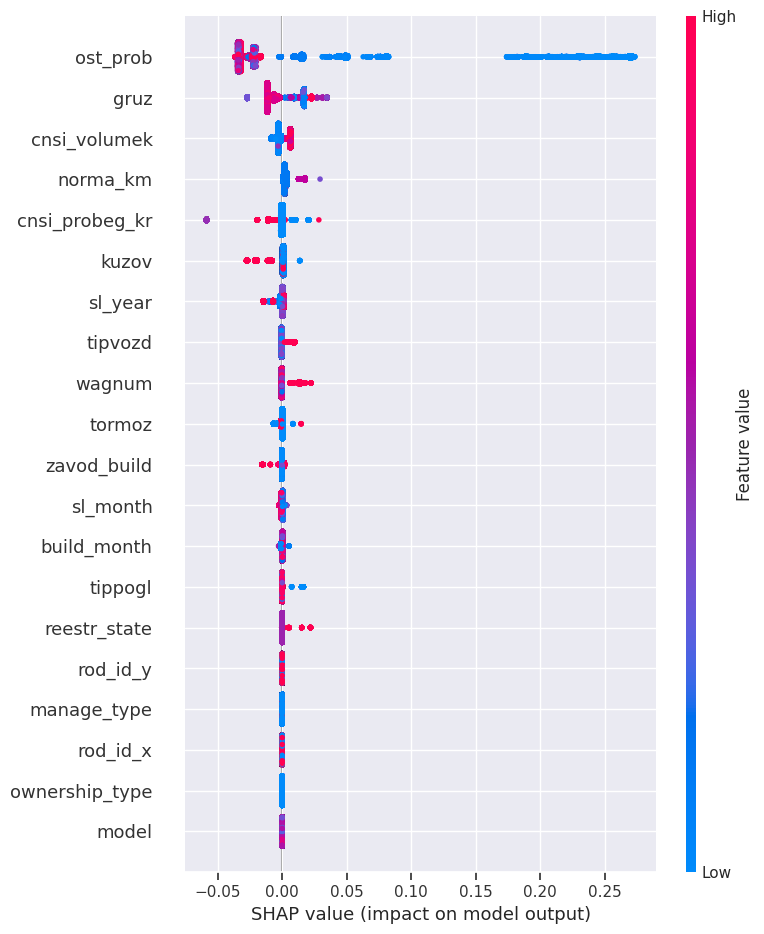

In [297]:
shap.summary_plot(shap_values, pd.concat([x_train, x_valid]))

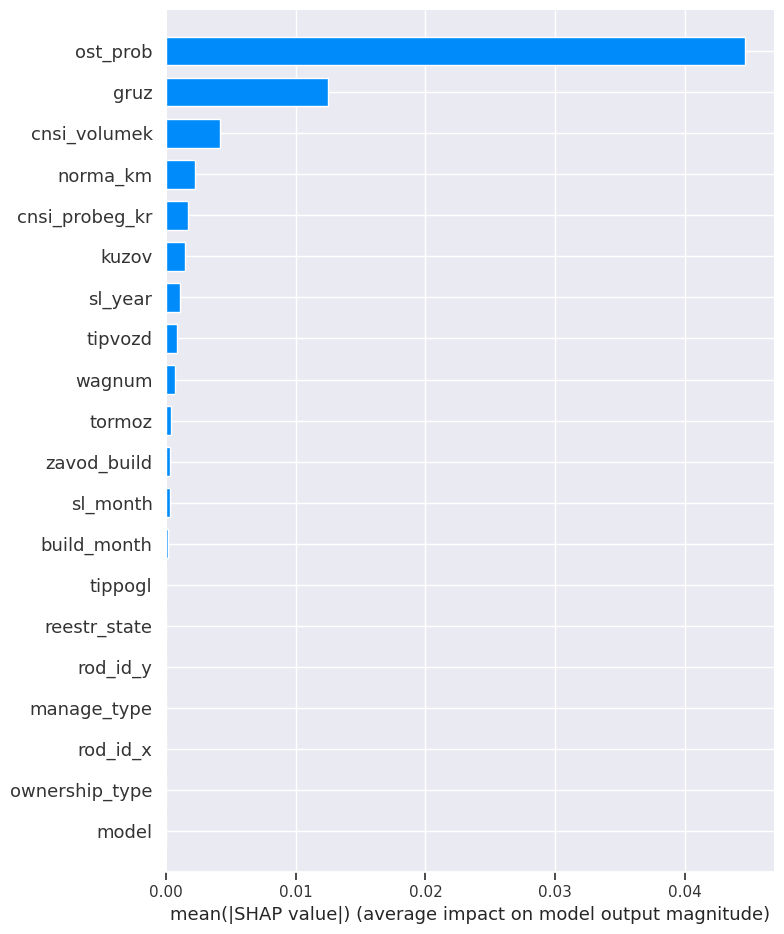

In [298]:
shap.summary_plot(shap_values, pd.concat([x_train, x_valid]), plot_type="bar")